In [161]:
# Configs

label_name = "math"
embedding_type = "perf" # time or perf

In [162]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize

import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
%matplotlib inline

In [163]:
dataset = pd.read_csv(f"../../dataset/{embedding_type}/small_{label_name}_dataset.csv")
dataset = pd.get_dummies(dataset)

dataset = dataset.filter(regex=("(branch-misses_FEATURE_TYPE_LOGLOG_POLYNOMIAL|branches_FEATURE_TYPE_LOGLOG_POLYNOMIAL|branches_FEATURE_TYPE_POLYNOMIAL|context-switches_FEATURE_TYPE_LOGLOG_POLYNOMIAL|context-switches_FEATURE_TYPE_LOG_POLYNOMIAL|cpu-migrations_FEATURE_TYPE_LOGLOG_POLYNOMIAL|cpu-migrations_FEATURE_TYPE_LOG_POLYNOMIAL|cycles_FEATURE_TYPE_LOGLOG_POLYNOMIAL|instructions_FEATURE_TYPE_LOGLOG_POLYNOMIAL|instructions_FEATURE_TYPE_POLYNOMIAL|page-faults_FEATURE_TYPE_LOGLOG_POLYNOMIAL|stalled-cycles-frontend_FEATURE_TYPE_LOGLOG_POLYNOMIAL|task-clock_FEATURE_TYPE_LOGLOG_POLYNOMIAL)"))

dataset=(dataset-dataset.min())/(dataset.max()-dataset.min())
dataset.head()

,branch-misses_FEATURE_TYPE_LOGLOG_POLYNOMIAL,branches_FEATURE_TYPE_LOGLOG_POLYNOMIAL,branches_FEATURE_TYPE_POLYNOMIAL,context-switches_FEATURE_TYPE_LOGLOG_POLYNOMIAL,context-switches_FEATURE_TYPE_LOG_POLYNOMIAL,cpu-migrations_FEATURE_TYPE_LOGLOG_POLYNOMIAL,cpu-migrations_FEATURE_TYPE_LOG_POLYNOMIAL,cycles_FEATURE_TYPE_LOGLOG_POLYNOMIAL,instructions_FEATURE_TYPE_LOGLOG_POLYNOMIAL,instructions_FEATURE_TYPE_POLYNOMIAL,page-faults_FEATURE_TYPE_LOGLOG_POLYNOMIAL,stalled-cycles-frontend_FEATURE_TYPE_LOGLOG_POLYNOMIAL,task-clock_FEATURE_TYPE_LOGLOG_POLYNOMIAL
0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0


In [164]:
labels = pd.read_csv(f"../../dataset/{embedding_type}/small_{label_name}_dataset.csv").filter(regex=("label"))
labels.head()

,label
0,0
1,0
2,1
3,0
4,0


In [165]:
data = dataset.copy().to_numpy() 
target = labels.copy().pop('label').to_numpy() 

In [166]:
from minisom import MiniSom    

# Initialization and training
n_neurons = 6
m_neurons = 6
som = MiniSom(n_neurons, m_neurons, data.shape[1], sigma=1, learning_rate=.05, random_seed=42, neighborhood_function='gaussian')

som.pca_weights_init(data)

/usr/local/lib/python3.9/site-packages/minisom.py:370: ComplexWarning: Casting complex values to real discards the imaginary part
  self._weights[i, j] = c1*pc[pc_order[0]] + c2*pc[pc_order[1]]


To understand how the training evolves we can plot the quantization and topographic error of the SOM at each step. This is particularly important when estimating the number of iterations to run:

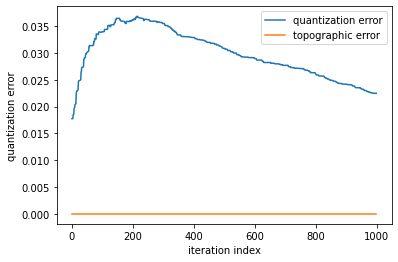

In [173]:
max_iter = 1000
q_error = []
t_error = []

for i in range(max_iter):
    rand_i = np.random.randint(len(data))
    som.update(data[rand_i], som.winner(data[rand_i]), i, max_iter)
    q_error.append(som.quantization_error(data))
    t_error.append(som.topographic_error(data))

plt.plot(np.arange(max_iter), q_error, label='quantization error')
plt.plot(np.arange(max_iter), t_error, label='topographic error')
plt.ylabel('quantization error')
plt.xlabel('iteration index')
plt.legend()
plt.show()

In [170]:
som.train(data, 1000, verbose=True)

 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 0.017573877520739557


To have an overview of how the samples are distributed across the map a scatter chart can be used where each dot represents the coordinates of the winning neuron. A random offset is added to avoid overlaps between points within the same cell


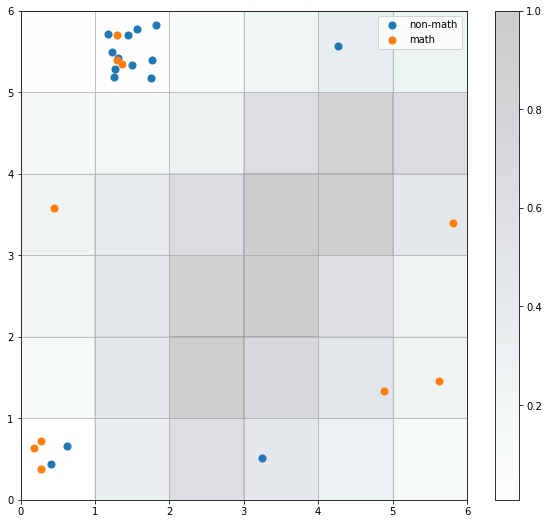

In [171]:
colors = ['C0', 'C1']

label_names = {0:'non-math', 1:'math'}

w_x, w_y = zip(*[som.winner(d) for d in data])
w_x=np.array(w_x)
w_y=np.array(w_y)

plt.figure(figsize=(10, 9))
plt.pcolor(som.distance_map().T, cmap='bone_r', alpha=.2)
plt.colorbar()

for c in np.unique(target):
    idx_target = target==c
    plt.scatter(w_x[idx_target]+.5+(np.random.rand(np.sum(idx_target))-.5)*.8,
                w_y[idx_target]+.5+(np.random.rand(np.sum(idx_target))-.5)*.8, 
                s=50, c=colors[c], label=label_names[c])
plt.legend(loc='upper right')
plt.grid()
plt.savefig('som_seed.png')
plt.show()

When dealing with a supervised problem, one can visualize the proportion of samples per class falling in a specific neuron using a pie chart per neuron:

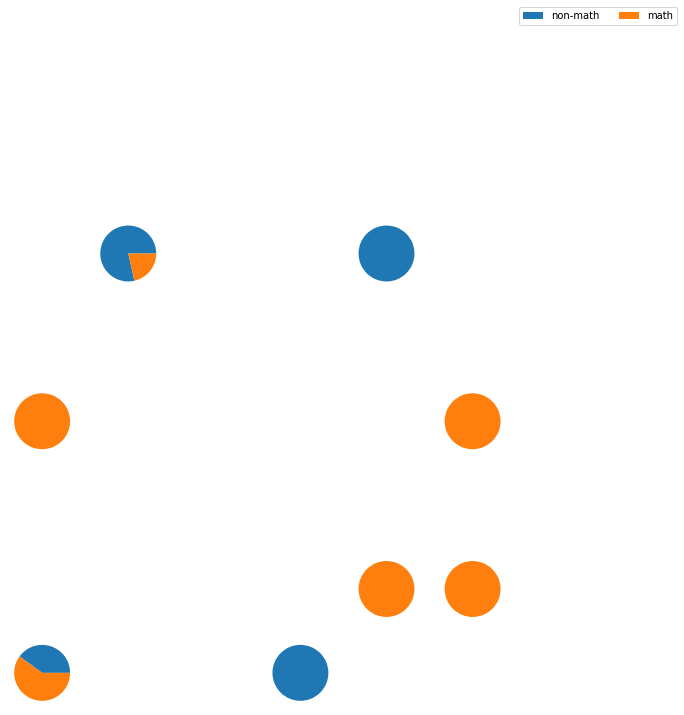

In [172]:
labels_map = som.labels_map(data, [label_names[t] for t in target])

fig = plt.figure(figsize=(9, 9))
the_grid = gridspec.GridSpec(n_neurons, m_neurons, fig)
for position in labels_map.keys():
    label_fracs = [labels_map[position][l] for l in label_names.values()]
    plt.subplot(the_grid[n_neurons-1-position[1],
                         position[0]], aspect=1)
    patches, texts = plt.pie(label_fracs)

plt.legend(patches, label_names.values(), bbox_to_anchor=(3.5, 6.5), ncol=3)
plt.savefig('som_seed_pies.png')
plt.show()